# KNN Classification of Weather

## Introduction

Weather warnings are important forecasts because they are used to protect life and property. Especially in Seattle, a city that rains often, forecasts are made based on temperature, precipitation to help determine future climate expectations. These forecasts help business and farmers plan for power usage, irrigation and protection and also help people plan activities and dress for the weather accordingly. 
 
This model aims to answer the question: **can we classify weather using daily precipitation, wind speed and average temperature as predictors**? The data set we obtained (source: https://www.kaggle.com/ananthr1/weather-prediction) contains daily observations of weather in Seattle, Washington between 2012 to 2015. The set of variables per observation in this data set is:
- date: the date of the observation
- precipitation: the amount of precipitation in any form (cm)
- temp_max: the maximum temperature (Celsius)
- temp_min: the minimum temperature (Celsius)
- wind: the wind speed (mph)
- weather: the type of weather (drizzle, rain, sun, snow, fog)

By understanding the relationships among these variables, it helps meteorologists better predict the weather for the public. Note that the original data set did not provide units, so we made a reasonable guess for each variable. (For example, 10°C is more reasonable than 10°F for temperature)

## Exploring the Dataset

In [9]:
# Run this code to set up the notebook
library(tidyverse)
library(repr)
library(tidymodels)
require("devtools")
install.packages("themis")
library("themis")
options(repr.matrix.max.rows = 6)
install.packages("knitr")
library(knitr)
library(cowplot)

Warning message in install.packages("themis"):
“installation of package ‘themis’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Warning message:
“package ‘cowplot’ was built under R version 4.0.3”


In [2]:
# Read the data into R (provided by https://www.kaggle.com/ananthr1/weather-prediction)
weather_data <- read_csv("https://raw.githubusercontent.com/irisxu02/dsci100-group13/main/weather.csv") %>%
    mutate(weather = as_factor(weather),
           temp_avg = (temp_max + temp_min)/2)
weather_data

Parsed with column specification:
cols(
  date = col_date(format = ""),
  precipitation = col_double(),
  temp_max = col_double(),
  temp_min = col_double(),
  wind = col_double(),
  weather = col_character()
)



date,precipitation,temp_max,temp_min,wind,weather,temp_avg
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
2012-01-01,0.0,12.8,5.0,4.7,drizzle,8.90
2012-01-02,10.9,10.6,2.8,4.5,rain,6.70
2012-01-03,0.8,11.7,7.2,2.3,rain,9.45
⋮,⋮,⋮,⋮,⋮,⋮,⋮
2015-12-29,0,7.2,0.6,2.6,fog,3.90
2015-12-30,0,5.6,-1.0,3.4,sun,2.30
2015-12-31,0,5.6,-2.1,3.5,sun,1.75


Now that we have tidy data, we would like to perform a summary to see how many observations of each type of weather we have. Is our data evenly distributed? 

In [3]:
# Count the number of observations for each weather type
weather_data_count <- weather_data %>%
    group_by(weather) %>%
    summarize(n = n())
kable(weather_data_count, caption = "The number of observations recorded for each type of weather")

`summarise()` ungrouping output (override with `.groups` argument)





Table: The number of observations recorded for each type of weather

|weather |   n|
|:-------|---:|
|drizzle |  53|
|rain    | 641|
|sun     | 640|
|snow    |  26|
|fog     | 101|

Our data is highly unbalanced with respect to our predictor variable. For this reason, we will upsample the rare weather in our data analysis.

### Visualization

We want to provide a plot of the data so we can get a visual overview of what we are working with.

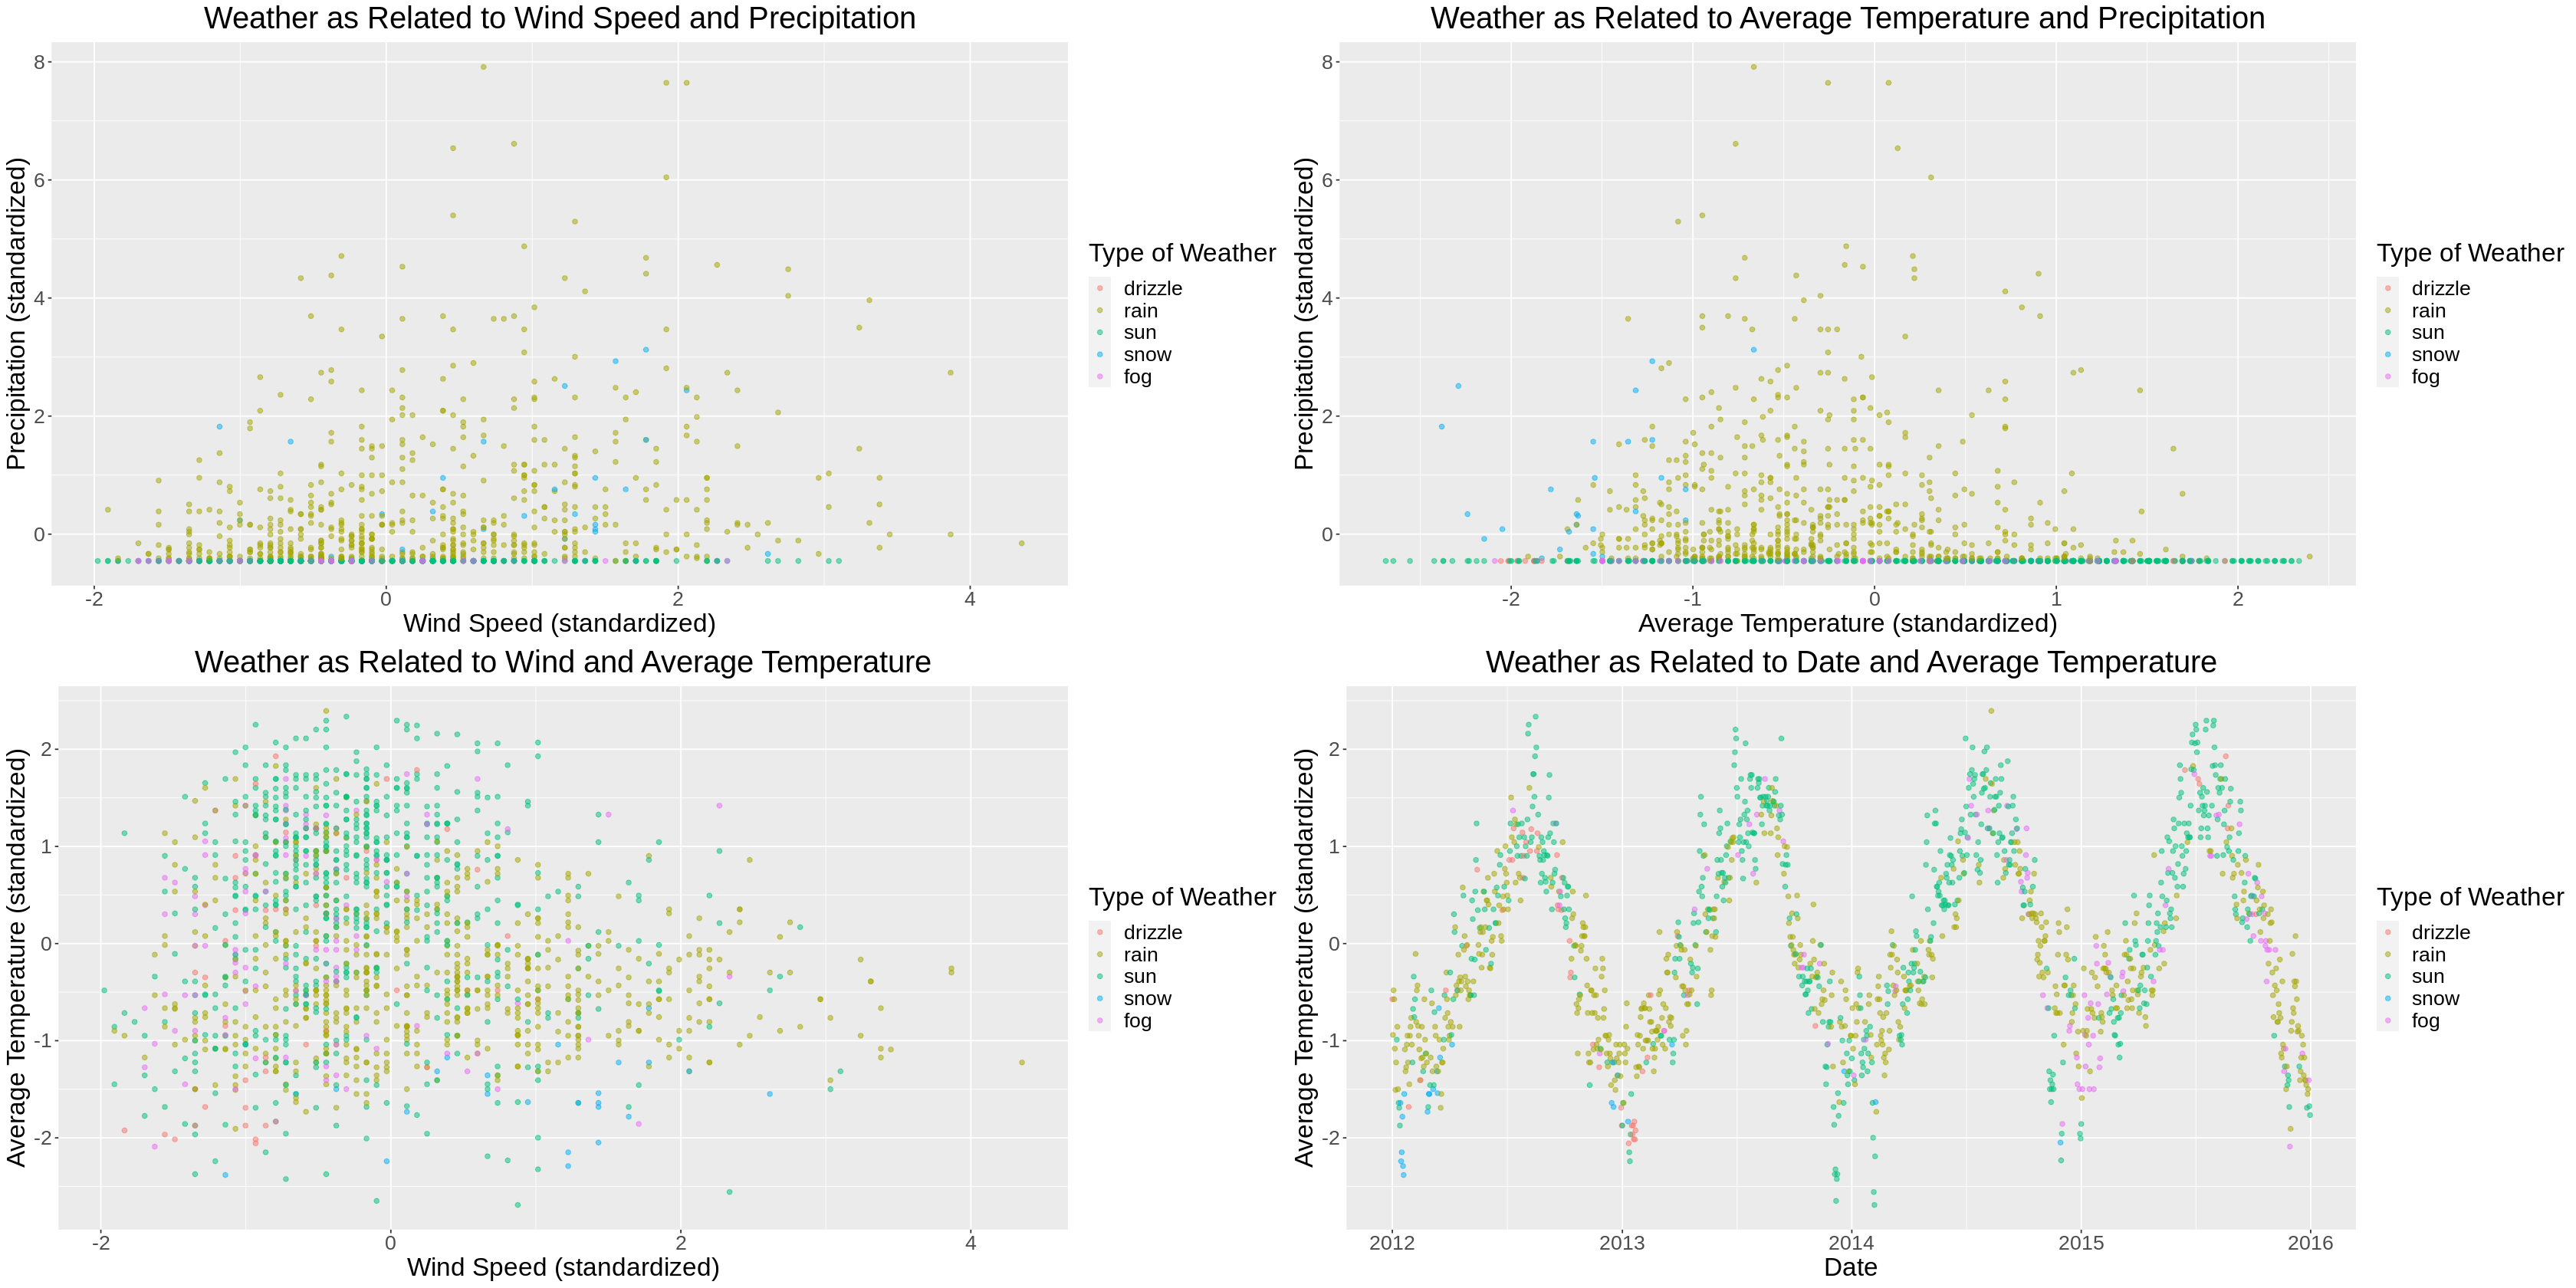

In [17]:
options(repr.plot.width = 28, repr.plot.height = 14)
# Scale the weather data
weather_data_scaled <- weather_data %>%
    mutate(scaled_precipitation = scale(precipitation, center = TRUE),
          scaled_wind = scale(wind, center = TRUE),
          scaled_temp_avg = scale(temp_avg, center = TRUE))
# Create scatterplots using ggplot to visualize the data
wind_prec_plot <- weather_data_scaled %>% 
    ggplot(aes(x = scaled_wind, y = scaled_precipitation)) +
    geom_point(aes(color = weather), alpha = 0.5) +
    labs(title = "Weather as Related to Wind Speed and Precipitation", color = "Type of Weather") +
    xlab("Wind Speed (standardized)") +
    ylab("Precipitation (standardized)") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
temp_prec_plot <- weather_data_scaled %>% 
    ggplot(aes(x = scaled_temp_avg, y = scaled_precipitation)) +
    geom_point(aes(color = weather), alpha = 0.5) +
    labs(title = "Weather as Related to Average Temperature and Precipitation", color = "Type of Weather") +
    xlab("Average Temperature (standardized)") +
    ylab("Precipitation (standardized)") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
wind_temp_plot <- weather_data_scaled %>% 
    ggplot(aes(x = scaled_wind, y = scaled_temp_avg)) +
    geom_point(aes(color = weather), alpha = 0.5) +
    labs(title = "Weather as Related to Wind and Average Temperature", color = "Type of Weather") +
    xlab("Wind Speed (standardized)") +
    ylab("Average Temperature (standardized)") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
date_temp_plot <- weather_data_scaled %>% 
    ggplot(aes(x = date, y = scaled_temp_avg)) +
    geom_point(aes(color = weather), alpha = 0.5) +
    labs(title = "Weather as Related to Date and Average Temperature", color = "Type of Weather") +
    xlab("Date") +
    ylab("Average Temperature (standardized)") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
# show the scatterplots side by side
plot_grid(wind_prec_plot, temp_prec_plot, wind_temp_plot, date_temp_plot, nrow = 2)

**TODO**
To explore our data, we made two graphs showing the relationships among the three predictors we plan to use; wind speed, precipitation, and average temperature. We chose to not focus on how the date affects weather because that would direct our focus on just Seattle itself. The weathers that correlate to the dates in this dataset are specific for Seattle, but we wanted to focus on other variables that will apply to other areas as well to classify weather. That way, our findings will be more relevent for a wider range of areas in the world.

**We will explain why we chose these specific three predictors to classify type of weather later in this section.**

Just observing all three graphs, we see that rain is the most common weather among both graphs. The majority of all the weathers are near the middle (average) regions for wind speed and on the lower end (below average) for precipitation. Rain and snow are below average temperatures whereas sun is above average temperture. The rest of the weather types quite scattered when it comes to average temperature, making it difficult to draw any specific conclusions. From these graphs, we cannot determine significant correlations, thus more tests are needed to decide which predicors we plan to use. In order to do this, we will do forward selection.

## Data Analysis

### Method Overview

**TO EDIT**
We will then split the data into training and testing sets with a 75%/25% train/test proportion and set the strata argument to weather since that is what we intend to classify. Our next step is to find the best K nearest neighbor that will render us highest accuracy. This process includes performing a 5-fold cross-validation, splitting the training set and preprocessing the data by specifying a recipe. We will upsample our data because, as described above, there is heavy imbalance among the weather types. After scaling and centering on all predictors, we will specify a model using nearest_neighbors, setting the neighbors = tune(). The workflow function will allow us to chain together our recipe and model and the tune_grid function will fit the model for each value in a range of parameter values. We will then plot parameter values against an accuracy estimate to visually determine best K value (with the highest accuracy). With that new K value, we will create a new model specification with what we found for K and retrain the classifier using the fit function. After creating a new workflow which includes the new model specification, we will use the predict function to evaluate the estimated accuracy of the classifier on the test set.

### Forward Selection

We want to know which variables to use as predictors in our data analysis. Here, we perform forward selection to select the most relevant predictors. We do not include date in our potential set of predictors because although it gives us a good idea what weather we should expect based on what season it is, it is not directly related to weather and definitely does not influence the type of weather we observe. We want our model to be generalizable to other locations, and seasonal trends could be very different based on location, so in the following step we test precipitation, temperature and wind variables to see which combination might give us the highest predictive accuracy.

In [60]:
# create a list consisting of variables we want to test
var_names <- list("precipitation", "temp_avg", "temp_max", "temp_min", "wind")
var_names

[[1]]
[1] "precipitation"

[[2]]
[1] "temp_avg"

[[3]]
[1] "temp_max"

[[4]]
[1] "temp_min"

[[5]]
[1] "wind"

In [61]:
# Set seed to 123 (do not change)
set.seed(123)
# create an empty tibble to store the results
fs_accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
fs_weather_vfold <- vfold_cv(weather_data, v = 5, strata = weather)

# store the total number of predictors
n_total <- length(var_names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(var_names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, var_names[[j]])
        model_string <- paste("weather", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        weather_recipe <- recipe(as.formula(model_string), data = weather_data) %>%
                          step_upsample(weather, over_ratio = 1)
                          step_scale(list(var_names)) %>%
                          step_center(list(var_names))

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(weather_recipe) %>%
          add_model(knn_tune) %>%
          tune_grid(resamples = fs_weather_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    fs_accuracies <- fs_accuracies %>%
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, var_names[[jstar]])
    var_names <- var_names[-jstar]
}
fs_accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,weather ~ precipitation,0.4400995
2,weather ~ precipitation+temp_avg,0.6700562
3,weather ~ precipitation+temp_avg+temp_min,0.6905903
4,weather ~ precipitation+temp_avg+temp_min+temp_max,0.6782332
5,weather ~ precipitation+temp_avg+temp_min+temp_max+wind,0.6652968


### Model Training

In [62]:
# Set seed to 100 (do not change)
set.seed(100)
# split the data set into training and testing sets
weather_split <- initial_split(weather_data, prop = 0.75, strata = weather)
weather_train <- training(weather_split)
weather_test <- testing(weather_split)

# create a nearest neighbor model with neighbors set to tune for this step
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# create a recipe with upsample, scale, and center
weather_recipe <- recipe(weather ~ precipitation + temp_avg + temp_min, data = weather_train) %>%
    step_upsample(weather, over_ratio = 1, skip = FALSE) %>%
    prep()
weather_bake <- bake(weather_recipe, weather_train)
weather_recipe <- recipe(weather ~ precipitation + temp_avg + temp_min, data = weather_bake) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# perform cross validation to find optimal k
weather_vfold <- vfold_cv(weather_train, v = 5, strata = weather)
knn_results <- workflow() %>%
    add_recipe(weather_recipe) %>%
    add_model(knn_tune)  %>%
    tune_grid(resamples = weather_vfold, grid = tibble(neighbors = seq(1, 10))) %>%
    collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.7047011,5,0.01196716,Model01
1,roc_auc,hand_till,0.6360250,5,0.01494736,Model01
2,accuracy,multiclass,0.7028579,5,0.01274106,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,hand_till,0.7412943,5,0.008402493,Model09
10,accuracy,multiclass,0.7658267,5,0.015819644,Model10
10,roc_auc,hand_till,0.7553546,5,0.012437464,Model10


Above we have the results of our cross validation step, but we only really care about the mean accuracy for the different number of neighbors 1 through 10. We can filter and select those variables/values from the tibble and show the results in a table.

In [63]:
# filter for accuracies
accuracies <- knn_results %>% filter(.metric == "accuracy") %>% select(neighbors, mean)
kable(accuracies, caption = "KNN Classification weather prediction accuracy estimates for different numbers of neighbors")



Table: KNN Classification weather prediction accuracy estimates for different numbers of neighbors

| neighbors|      mean|
|---------:|---------:|
|         1| 0.7047011|
|         2| 0.7028579|
|         3| 0.7466567|
|         4| 0.7585623|
|         5| 0.7639793|
|         6| 0.7658141|
|         7| 0.7612521|
|         8| 0.7658183|
|         9| 0.7649009|
|        10| 0.7658267|

However, it is difficult to read a table at first glance. Instead, we visualize the prediction accuracies with respect to the number of neighbors below for a more intuitive picture.

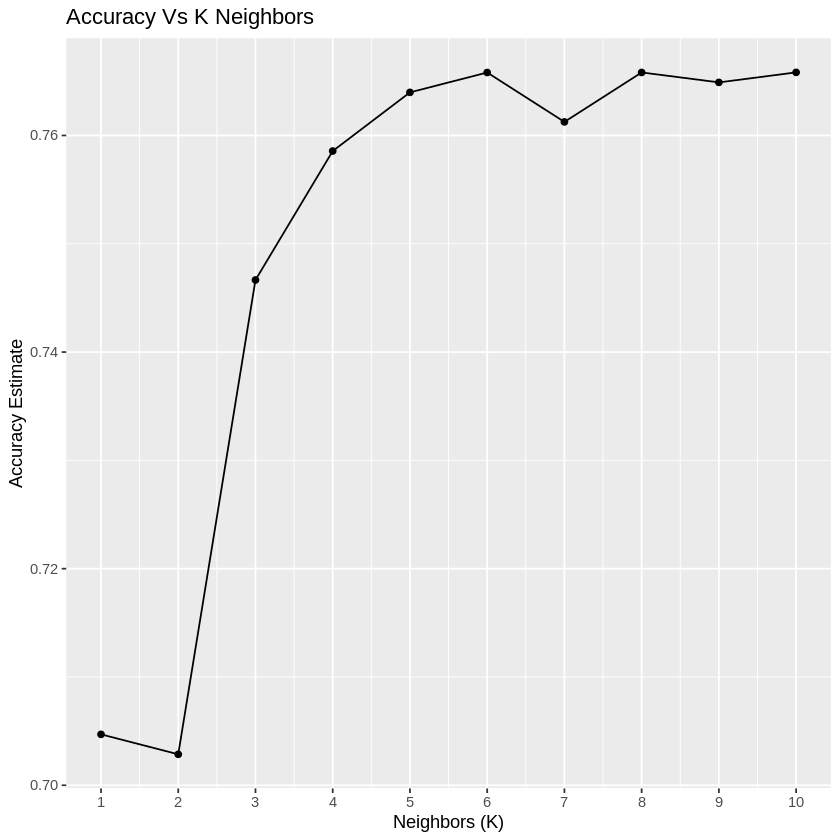

In [64]:
options(repr.plot.width = 7, repr.plot.height = 7)

# plot to visualize accuracies vs number of neighbors (k)
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
       geom_point() +
       geom_line() +
       labs(x = "Neighbors (K)", y = "Accuracy Estimate") +
       ggtitle("Accuracy Vs K Neighbors") +
       scale_x_continuous(breaks = seq(0, 10, by = 1))  # adjusting the x-axis

accuracy_versus_k

EXPLAIN THE LIMITATIONS TO THIS GRAPH

It appears that the accuracy of the model keeps improving when $k$ increases, $k\ge2$. However we notice that with $k$ greater than 5, the accuracy only improves minimally. Moreover, we keep in mind that KNN algorithm slows with higher k values, we choose to take $k=5$. This is the number of neighbors for the KNN classification model that would give us a relatively high prediction accuracy while not slowing the algorithm too much, so we use it in creating our final model below.

In [68]:
# select best k
best_k <- 5
# create new model and set neighbors to best k value found through cross validation
weather_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) %>%
    set_engine("kknn") %>%
    set_mode("classification")
weather_fit <- workflow() %>%
       add_recipe(weather_recipe) %>%
       add_model(weather_spec) %>%
       fit(data = weather_train)
weather_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~best_k,     kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2242479
Best kernel: rectangular
Best k: 5

### Predictions and Model Accuracy

At this point, we are ready to use our model on our testing data set to make some predictions!

In [69]:
weather_predictions <- predict(weather_fit, weather_test)  %>%
    bind_cols(weather_test)
weather_predictions
weather_metrics <- weather_predictions %>%
    metrics(truth = weather, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
weather_metrics

.pred_class,date,precipitation,temp_max,temp_min,wind,weather,temp_avg
<fct>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
rain,2012-01-01,0.0,12.8,5.0,4.7,drizzle,8.90
rain,2012-01-02,10.9,10.6,2.8,4.5,rain,6.70
rain,2012-01-03,0.8,11.7,7.2,2.3,rain,9.45
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
rain,2015-12-28,1.5,5.0,1.7,1.3,rain,3.35
sun,2015-12-30,0.0,5.6,-1.0,3.4,sun,2.30
sun,2015-12-31,0.0,5.6,-2.1,3.5,sun,1.75


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7582418


We see that the accuracy of our model is approximately 75.8%.

In [72]:
weather_conf_mat <- weather_predictions %>%
    conf_mat(truth = weather, estimate = .pred_class) %>%
    print()

          Truth
Prediction drizzle rain sun snow fog
   drizzle       3    0   0    0   0
   rain          3  131  10    3   1
   sun           7   25 141    2  21
   snow          0    0   0    1   0
   fog           2    2  12    0   0


### Model Visualization

In [76]:
# create the grid of precipitation/temp_avg/wind vals, and arrange in a data frame
prec_grid <- seq(min(weather_data$precipitation), 
                max(weather_data$precipitation), 
                length.out = 100)
tmpa_grid <- seq(min(weather_data$temp_avg), 
                max(weather_data$temp_avg), 
                length.out = 100)
tmpmin_grid <- seq(min(weather_data$temp_min), 
                max(weather_data$temp_min), 
                length.out = 100)
ptwgrid <- as_tibble(expand.grid(Precipitation = prec_grid, 
                                Temp_Avg = tmpa_grid,
                                Wind = tmpmin_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(weather_fit, ptwgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, ptwgrid) %>% 
  rename(weather = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = weather_data, 
             mapping = aes(x = Temp_Avg, 
                           y = Precipitation, 
                           color = weather), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = Temp_Avg, 
                           y = Precipitation, 
                           color = weather), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Diagnosis", 
       x = "Wind (standardized)", 
       y = "Precipitation (standardized)") +
  scale_color_manual(labels = c("Drizzle", "Rain", "Sun", "Snow", "Fog"), 
                     values = c("orange2", "steelblue2", "red2", "green2", "yellow2")) +
  theme(text = element_text(size = 12))

wkflw_plot

ERROR: Error: The following required columns are missing: 'precipitation', 'temp_avg', 'temp_min'.


## Discussion

- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

**TODO**
We can see that the model is relatively accurate in predicting rain and sun, however it failed to predict snow and fog accurately, with 50% and 10%
accuracy respectively. This could be due to lack of available data points of rare weathers.

We could also look at improving our model. With the data available, we can further try different combinations of variables in our forward selection step to select a better set of variables with more predictive power. But are there other variables which we can interpret that do well at predicting the type of weather? For example, we are curious as to whether temperature difference (temp_max - temp_min) would be a good predictor and if it can improve our prediction accuracy. There are likely many variables that aren't even included in this data set that data scientists use for applications in meteorology and studies surrounding weather and climate change.



## References

R, A. (2022, January 17). Weather Prediction. Kaggle. Retrieved March 11, 2022, from https://www.kaggle.com/ananthr1/weather-prediction

April 30, 2020. (n.d.). Weather and applied statistics. Michigan Technological University. Retrieved April 5, 2022, from https://onlinedegrees.mtu.edu/news/weather-applied-statistics

- why/how we chose predictor variables / how weather is related to these variables
- why our question is important